## LAB 1: Bag of Visual Words Image Classification

Team 3: Zuzana Szafranowska, Claudia Baca, Quim Comas

In [1]:
import cv2
import numpy as np
import cPickle
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier

Let us first read the train and test files

In [2]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','r'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','r'))
train_labels = cPickle.load(open('train_labels.dat','r'))
test_labels = cPickle.load(open('test_labels.dat','r'))

We create a SIFT object detector and descriptor

In [4]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
SURFdetector = cv2.xfeatures2d.SURF_create(300)
ORBdetector = cv2.ORB_create(300)

We choose the type of local feature detector that we want to use. 

- 1 ==> SIFT
- 2 ==> SURF
- 3 ==> ORB


In [5]:
x = input("Enter a number to choose the local feature detector: ")

Enter a number to choose the local feature detector: 4


We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [6]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)


D=np.vstack(Train_descriptors)

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/features2d/src/feature2d.cpp:154: error: (-213:The function/feature is not implemented)  in function 'detectAndCompute'


We now compute a k-means clustering on the descriptor space

In [ ]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [ ]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in xrange(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

To see the effect of K value in KNN classifier we perform a cross validation with our training set to estimate the optimal K value. Also we represent the evolution of the accuracy for each k value to see the influence of the k value:   

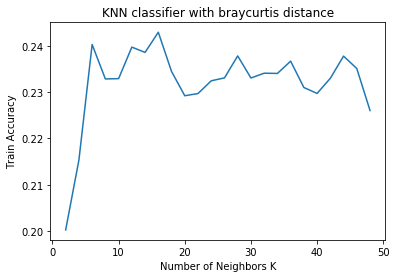

The optimal k value is 16


In [51]:
neighbors = filter(lambda x: x % 2 == 0, list(range(1,50)))
cv_scores = []

for kk in neighbors:
    knn = KNeighborsClassifier(n_neighbors=kk,n_jobs=-1,metric='chebyshev')
    scores = cross_val_score(knn, visual_words, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.title('KNN classifier with braycurtis distance')
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

print "The optimal k value is %d" % optimal_k

We build a k-nn classifier and train it with the train descriptors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

We end up computing the test descriptors and compute the accuracy of the model

In [ ]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
        
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [ ]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

Accuracy's results are:

SIFT:

| Distance | Initial parameters | Optimal K |
| --- | --- | --- |
| Euclidean |  53.5315 | 55.8859 |
| Chebyshev |  43.2465 | 44.6096 |
| Manhattan |  50.1858 | 52.4163 |
|  Hamming  |  35.1920 | 37.5464 |
| Canberra  |  50.1858 | 51.6728 |
|Braycurtis |  57.1250 | 57.6208 |


SURF:

| Distance | Initial parameters | Optimal K |
| --- | --- | --- |
| Euclidean |  54.7707 | 57.0012 |
| Chebyshev |  46.8401 | 49.5662 |
| Manhattan |  53.5315 | 53.5315 |
|  Hamming  |  35.9355 | 37.1747 |
| Canberra  |  55.7620 | 56.2577 |
|Braycurtis |  62.5774 | 63.8166 |


ORB:

| Distance | Initial parameters | Optimal K |
| --- | --- | --- |
| Euclidean |  29.8636 | 31.8463 |
| Chebyshev |  22.6765 | 24.5353 |
| Manhattan |  29.7397 | 33.8289 |
|  Hamming  |  23.0483 | 25.5266 |
| Canberra  |  27.3853 | 27.1375 |
|Braycurtis |  27.5092 | 29.2441 |














